In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Libraries

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sb
import os
import random as rand
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix

# Data engineering

In [3]:
!ls ../input/titanic/

gender_submission.csv  test.csv  train.csv


In [4]:
train_data_path = '../input/titanic/train.csv'
test_data_path = '../input/titanic/test.csv'

## Test data 
Explore test data 

In [5]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.columns



Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Test data

In [8]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
titanic_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [10]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Data preparation

## Select reduce columns 

In [11]:
titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
titanic_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

I propose to keep Pclass,Sex, Age, SibSP,Parch,Ticket, Fare,Cabin, Embarked, Survived

In [13]:
columns_to_keep = ['PassengerId','Pclass', 'Sex',  'Age',  'SibSp', 'Parch','Ticket', 'Fare','Cabin', 'Embarked', 'Survived']
titanic_train = titanic_train.loc[:,columns_to_keep]
titanic_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,male,35.0,0,0,373450,8.0500,NaN,S,0


In [14]:
columns_to_keep = ['PassengerId','Pclass', 'Sex',  'Age',  'SibSp', 'Parch','Ticket', 'Fare','Cabin', 'Embarked']
titanic_test = titanic_test.loc[:,columns_to_keep]
titanic_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S


# Passengers ID
Drop. 
old : Transforms to float

In [15]:
#titanic_train.drop("PassengerId", axis = 1)
#titanic_test.drop("PassengerId", axis = 1)
titanic_train["PassengerId"] = titanic_train["PassengerId"].astype(float)
titanic_test["PassengerId"]  = titanic_test["PassengerId"].astype(float)

# Number of sibling

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

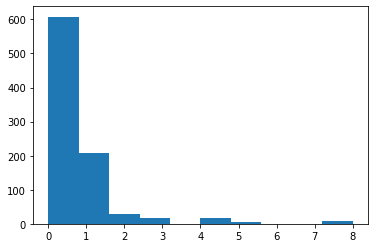

In [16]:
print(titanic_train["SibSp"].describe())
plt.hist(titanic_train["SibSp"])

count    418.000000
mean       0.447368
std        0.896760
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


(array([283., 110.,  14.,   4.,   0.,   4.,   1.,   0.,   0.,   2.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

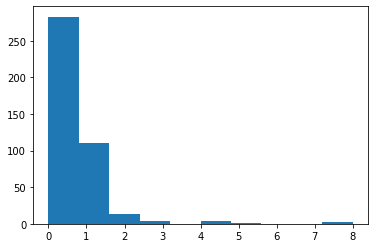

In [17]:
print(titanic_test["SibSp"].describe())
plt.hist(titanic_test["SibSp"])

In [18]:
def categorise_siblings(data):
    cut_labels_9 = ['sib_0','sib_1','sib_2','sib_3', 
                    'sib_4','sib_5','sib_6','sib_7', 'sib_8']
    cut_bins = [0,1,2,3,4,5,6,7,8,9]
    data['Sib_cat'] = pd.cut(data['SibSp'], 
                             bins=cut_bins, 
                             labels=cut_labels_9)
    
    data['Sib_cat'] = data.Sib_cat.astype(str)
    data.loc[data["Sib_cat"] == 'nan', "Sib_cat"] = "Sib_Unknown"
    
    return data

In [19]:
def transform_sibling_cat(data):
    factors = data['Sib_cat'].unique()
    gender_columns = pd.get_dummies(data['Sib_cat'])
    columns = range(0,len(factors))
    for column in columns:
        data[factors[column]] = gender_columns.loc[:, factors[column]].astype(float)
        
    return data

In [20]:
titanic_train = categorise_siblings(titanic_train)
titanic_train = transform_sibling_cat(titanic_train)
titanic_train = titanic_train.drop("SibSp", axis = 1)
titanic_train = titanic_train.drop("Sib_cat", axis = 1)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Sex             object
Age            float64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
dtype: object

In [21]:
titanic_train.shape

(891, 17)

In [22]:
titanic_test = categorise_siblings(titanic_test)
titanic_test = transform_sibling_cat(titanic_test)
titanic_test = titanic_test.drop("SibSp", axis = 1)
titanic_test = titanic_test.drop("Sib_cat", axis = 1)
titanic_test.dtypes

PassengerId    float64
Pclass           int64
Sex             object
Age            float64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
dtype: object

In [23]:
titanic_test.shape

(418, 16)

# Transforming age into categories
The categorise the age into 9 categories; unknown and one for each decade. The categories are then transformed in hot_coding format. 

titanic_train['Age'].unique()

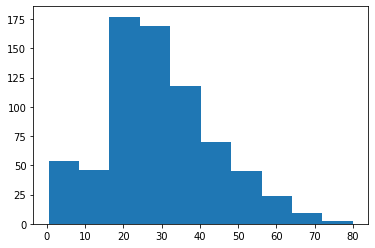

In [24]:
plt.hist(titanic_train['Age'], bins=10)
plt.show()

In [25]:
titanic_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

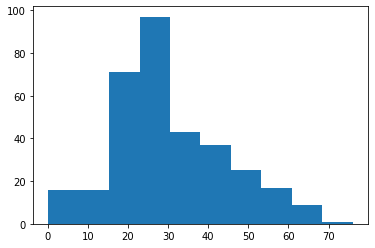

In [26]:
plt.hist(titanic_test['Age'], bins=10)
plt.show()

In [27]:
titanic_test['Age'].describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

In [28]:
def transform_age_cat(data):
    factors = data['Age_cat'].unique()
    gender_columns = pd.get_dummies(data['Age_cat'])
    columns = range(0,len(factors))
    for column in columns:
        data[factors[column]] = gender_columns.loc[:, factors[column]].astype(float)
        
    return data


In [29]:
def categorise_age(data):
    cut_labels_8 = ['age_0-9','age_10-19','age_20-29','age_30-39', 
                    'age_40-49','age_50-59','age_60-69','age_70-79']
    cut_bins = [0,10,20,30,40,50,60,70,80]
    data['Age_cat'] = pd.cut(data['Age'], 
                             bins=cut_bins, 
                             labels=cut_labels_8)
    data['Age_cat'] = data.Age_cat.astype(str)
    data.loc[data["Age"].isna(), "Age_cat"] = "Age_Unknown"
    return data

In [30]:
titanic_train = categorise_age(titanic_train)
titanic_train = transform_age_cat(titanic_train)
titanic_train = titanic_train.drop("Age", axis = 1)
titanic_train = titanic_train.drop("Age_cat", axis = 1)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Sex             object
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
age_20-29      float64
age_30-39      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_10-19      float64
age_60-69      float64
age_40-49      float64
age_70-79      float64
dtype: object

In [31]:
titanic_test = categorise_age(titanic_test)
titanic_test = transform_age_cat(titanic_test)
titanic_test = titanic_test.drop("Age", axis = 1)
titanic_test = titanic_test.drop("Age_cat", axis = 1)
titanic_test.dtypes

PassengerId    float64
Pclass           int64
Sex             object
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
age_30-39      float64
age_40-49      float64
age_60-69      float64
age_20-29      float64
age_10-19      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_70-79      float64
dtype: object

## Gender transformation to hot-coding 
We check the factor values are the same between both datasets. Then, we generate a hot coding of two columns; i.e., male and female. Both columns replace the Sex column.

In [32]:
titanic_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [33]:
titanic_test['Sex'].unique()

array(['male', 'female'], dtype=object)

In [34]:
def transform_gender(data):
    factors = data['Sex'].unique()
    gender_columns = pd.get_dummies(data['Sex'])
    columns = range(0,len(factors))
    
    for column in columns:
        data[factors[column]] = gender_columns.loc[:,factors[column]].astype(float)
        
    return data
    

In [35]:
titanic_train = transform_gender(titanic_train)
titanic_train.drop("Sex", axis = 1, inplace = True)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
age_20-29      float64
age_30-39      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_10-19      float64
age_60-69      float64
age_40-49      float64
age_70-79      float64
male           float64
female         float64
dtype: object

In [36]:
titanic_test = transform_gender(titanic_test)
titanic_test.drop("Sex", axis = 1,inplace = True)
titanic_test.head()

,PassengerId,Pclass,Parch,Ticket,Fare,Cabin,Embarked,Sib_Unknown,sib_0,sib_1,...,age_40-49,age_60-69,age_20-29,age_10-19,Age_Unknown,age_50-59,age_0-9,age_70-79,male,female
0,892.0,3,0,330911,7.8292,NaN,Q,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,893.0,3,0,363272,7.0000,NaN,S,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,894.0,2,0,240276,9.6875,NaN,Q,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,895.0,3,0,315154,8.6625,NaN,S,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,896.0,3,1,3101298,12.2875,NaN,S,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Cabin and Pclass

The passenger class appears to drive whether a cabin is known. So, we propose to drop the cabin as the percentage of not known values is quite high. We apply an hot encoding the Pclass. 

In [37]:
titanic_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [38]:
print("percentage of cabin  nan values - training ", titanic_train['Cabin'].isna().sum()/titanic_train.shape[0])
print("percentage of cabin  nan values - test ", titanic_test['Cabin'].isna().sum()/titanic_test.shape[0])

percentage of cabin  nan values - training  0.7710437710437711
percentage of cabin  nan values - test  0.7822966507177034


In [39]:
titanic_train['Pclass'].unique()

array([3, 1, 2])

In [40]:
titanic_test['Pclass'].unique()

array([3, 2, 1])

In [41]:
titanic_train.loc[titanic_train['Pclass'] == 1 ,['Pclass','Cabin']]

,Pclass,Cabin
1,1,C85
3,1,C123
6,1,E46
11,1,C103
23,1,A6
...,...,...
871,1,D35
872,1,B51 B53 B55
879,1,C50
887,1,B42


In [42]:
titanic_train.loc[titanic_train['Pclass'] == 2 ,['Pclass','Cabin']]

,Pclass,Cabin
9,2,NaN
15,2,NaN
17,2,NaN
20,2,NaN
21,2,D56
...,...,...
866,2,NaN
874,2,NaN
880,2,NaN
883,2,NaN


In [43]:
titanic_train.loc[titanic_train['Pclass'] == 3 ,['Pclass','Cabin']]

,Pclass,Cabin
0,3,NaN
2,3,NaN
4,3,NaN
5,3,NaN
7,3,NaN
...,...,...
882,3,NaN
884,3,NaN
885,3,NaN
888,3,NaN


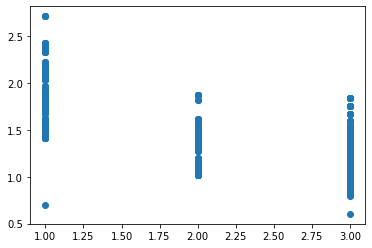

In [44]:
xs = titanic_train.loc[titanic_train['Fare'] > 0,'Pclass']
ys = np.log10(titanic_train.loc[titanic_train['Fare'] > 0,'Fare'])
plt.scatter(xs,ys)

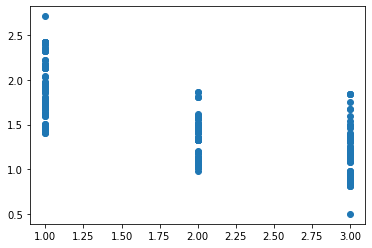

In [45]:
xs = titanic_test.loc[titanic_test['Fare'] > 0,'Pclass']
ys = np.log10(titanic_test.loc[titanic_test['Fare'] > 0,'Fare'])
plt.scatter(xs,ys)

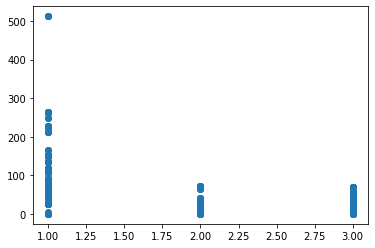

In [46]:
plt.scatter(titanic_train["Pclass"],titanic_train["Fare"])

In [47]:
def transform_Pclass(data):
    factors = data['Pclass'].unique()
    Pclass_columns = pd.get_dummies(data['Pclass'])
    columns = range(0,len(factors))
    
    for column in columns:
        col_name = 'Class_' + str(factors[column])
        data[col_name] = Pclass_columns.loc[:,factors[column]].astype(float)
        
    data.drop("Pclass", axis = 1)
    return data
    

In [48]:
titanic_train = transform_Pclass(titanic_train)
titanic_train.drop("Pclass", axis = 1, inplace = True)
titanic_train.drop("Cabin", axis = 1, inplace = True)
titanic_train.head()

,PassengerId,Parch,Ticket,Fare,Embarked,Survived,sib_0,Sib_Unknown,sib_2,sib_3,...,age_0-9,age_10-19,age_60-69,age_40-49,age_70-79,male,female,Class_3,Class_1,Class_2
0,1.0,0,A/5 21171,7.2500,S,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2.0,0,PC 17599,71.2833,C,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3.0,0,STON/O2. 3101282,7.9250,S,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,4.0,0,113803,53.1000,S,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,5.0,0,373450,8.0500,S,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [49]:
titanic_test = transform_Pclass(titanic_test)
titanic_test.drop("Pclass", axis = 1, inplace = True)
titanic_test.drop("Cabin", axis = 1, inplace = True)
titanic_test.head()

,PassengerId,Parch,Ticket,Fare,Embarked,Sib_Unknown,sib_0,sib_1,sib_2,sib_3,...,age_10-19,Age_Unknown,age_50-59,age_0-9,age_70-79,male,female,Class_3,Class_2,Class_1
0,892.0,0,330911,7.8292,Q,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,893.0,0,363272,7.0000,S,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,894.0,0,240276,9.6875,Q,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,895.0,0,315154,8.6625,S,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,896.0,1,3101298,12.2875,S,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# Tickets and Fare
We remove the tickets, as it brings no additional characteristic for the prediction.

Old version: We reduce the complexity of the Fare by using the log.
New version: The price appears to be dependent on the class, so we drop the price.

In [50]:
titanic_train.drop("Ticket", axis = 1, inplace = True)
titanic_test.drop("Ticket", axis = 1, inplace = True)

In [51]:
log_10_values = np.log10(titanic_train.loc[titanic_train['Fare'] > 0,'Fare'])
titanic_train.loc[titanic_train['Fare'] > 0,'Fare'] = log_10_values
titanic_train.Fare.describe()


count    891.000000
mean       1.256781
std        0.435553
min        0.000000
25%        0.898198
50%        1.159994
75%        1.491362
max        2.709549
Name: Fare, dtype: float64

In [52]:
log_10_values = np.log10(titanic_test.loc[titanic_test['Fare'] > 0,'Fare'])
titanic_test.loc[titanic_test['Fare'] > 0,'Fare'] = log_10_values
titanic_test.Fare.describe()

count    417.000000
mean       1.279591
std        0.437507
min        0.000000
25%        0.897396
50%        1.159994
75%        1.498311
max        2.709549
Name: Fare, dtype: float64

In [53]:
titanic_train.drop("Fare", axis = 1, inplace = True)
titanic_test.drop("Fare", axis = 1, inplace = True)

# Embarked 
Embarked has three values "S", 'C', 'Q' and some values unknown. So, we replace the unknown values with U. A hot-encoding transforms the values into columns. 

The test datasets has no unknown values; so we had a column 'U' for consistency with hot-encoding. 


In [54]:
titanic_train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [55]:
titanic_train.loc[titanic_train['Embarked'].isna(),'Embarked'] = 'U'
titanic_train.Embarked.unique()

array(['S', 'C', 'Q', 'U'], dtype=object)

In [56]:
titanic_test.loc[titanic_test['Embarked'].isna(),'Embarked'] = 'U'
titanic_test.Embarked.unique()

array(['Q', 'S', 'C'], dtype=object)

In [57]:
def transform_embarked(data):
    factors = data['Embarked'].unique()
    gender_columns = pd.get_dummies(data['Embarked'])
    columns = range(0,len(factors))
    
    for column in columns:
        data[factors[column]] = gender_columns.loc[:,factors[column]].astype(float)
        
    return data
    

In [58]:
titanic_train = transform_embarked(titanic_train)
titanic_train.drop("Embarked", axis = 1, inplace = True)
titanic_test  = transform_embarked(titanic_test)
titanic_test.drop("Embarked", axis = 1, inplace = True)


In [59]:
indices       = range(0, titanic_test.shape[0])
titanic_test['U'] = [0 for i in indices]
titanic_test['U'] = titanic_test['U'].astype(float)

# Outcome of data preparations

In [60]:

print("training datasets : " , titanic_train.shape)
titanic_train.dtypes

training datasets :  (891, 28)


PassengerId    float64
Parch            int64
Survived         int64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
age_20-29      float64
age_30-39      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_10-19      float64
age_60-69      float64
age_40-49      float64
age_70-79      float64
male           float64
female         float64
Class_3        float64
Class_1        float64
Class_2        float64
S              float64
C              float64
Q              float64
U              float64
dtype: object

In [61]:
print("testing datasets : " , titanic_test.shape)
titanic_test.dtypes

testing datasets :  (418, 27)


PassengerId    float64
Parch            int64
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
age_30-39      float64
age_40-49      float64
age_60-69      float64
age_20-29      float64
age_10-19      float64
Age_Unknown    float64
age_50-59      float64
age_0-9        float64
age_70-79      float64
male           float64
female         float64
Class_3        float64
Class_2        float64
Class_1        float64
Q              float64
S              float64
C              float64
U              float64
dtype: object

In [62]:
train_cols = titanic_train.columns
test_cols = titanic_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

Index(['Survived'], dtype='object')

In [63]:
titanic_test.columns

Index(['PassengerId', 'Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2',
       'sib_3', 'sib_4', 'sib_7', 'age_30-39', 'age_40-49', 'age_60-69',
       'age_20-29', 'age_10-19', 'Age_Unknown', 'age_50-59', 'age_0-9',
       'age_70-79', 'male', 'female', 'Class_3', 'Class_2', 'Class_1', 'Q',
       'S', 'C', 'U'],
      dtype='object')

# Cross validation preparation
We use a stratified sampling for the training into a train and test dataset. 

In [64]:
x_cols = ['Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2', 'sib_3', 'sib_4', 'sib_7', 'age_30-39', 'age_40-49', 'age_60-69', 'age_20-29', 'age_10-19', 'Age_Unknown', 'age_50-59',
       'age_0-9', 'age_70-79', 'male', 'female', 'Class_3', 'Class_2',
       'Class_1', 'Q', 'S', 'C', 'U']
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test  = X.iloc[test_valid_index]
    y_test  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_test.value_counts(normalize=True))

0    0.616105
1    0.383895
Name: Survived, dtype: float64 


0    0.616246
1    0.383754
Name: Survived, dtype: float64


In [65]:
X_train.shape

(534, 26)

In [66]:
X_test.shape

(357, 26)

In [67]:
y_train_encode=pd.get_dummies(y_train)
y_test_encode=pd.get_dummies(y_test)


In [68]:
train_cols = X_train.columns
test_cols = titanic_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

Index([], dtype='object')

In [69]:


no_columns = X_train.shape[1]
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(no_columns,)))
model.add(tf.keras.layers.Dense(50, activation="sigmoid"))
model.add(tf.keras.layers.Dense(50, activation="sigmoid"))
model.add(tf.keras.layers.Dense(2, activation="softmax"))


2022-12-06 15:36:46.606134: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


version_1
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(560, activation="sigmoid"))
model.add(tf.keras.layers.Dense(1120, activation="sigmoid"))
model.add(tf.keras.layers.Dense(1120, activation="sigmoid"))
model.add(tf.keras.layers.Dense(560, activation="sigmoid"))
model.add(tf.keras.layers.Dense(560, activation="sigmoid"))
model.add(tf.keras.layers.Dense(2, activation="softmax"))

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 26)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1350      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 4,002
Trainable params: 4,002
Non-trainable params: 0
_________________________________________________________________


In [71]:
best_recall = 0.0
learning_rates = np.arange(0.0001,0.0005,0.00001)

for rate in learning_rates:
    print("=== rates ===", rate)
    opt = tf.keras.optimizers.Adam(learning_rate = rate)
    model.compile(optimizer= opt, 
                  loss = "binary_crossentropy",
                  metrics=["accuracy"])

    history = model.fit(X_train,
                        y_train_encode,
                        validation_data=(X_test, y_test_encode),
                        epochs = 10,
                        verbose = False)
    y_pred = model.predict(X_test)
    Y_pred = np.argmax(model.predict(X_test),axis=1)
    cm = confusion_matrix(y_test, Y_pred)
    recall = cm[1][1]/(cm[0][1] + cm[1][1]) #TP/(TP+FN)
    
    if recall > best_recall:
        best_recall = recall
        best_rate   = rate 
        print("=== best recall ===" , recall)

    if best_recall == 1.0:
        break

=== rates === 0.0001


2022-12-06 15:36:47.062720: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001
=== best recall === 1.0


In [72]:

opt = tf.keras.optimizers.Adam(learning_rate = best_rate)
model.compile(optimizer= opt, 
              loss = "binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                    y_train_encode,
                    validation_data=(X_test, y_test_encode),
                    epochs = 800,
                    verbose = False)

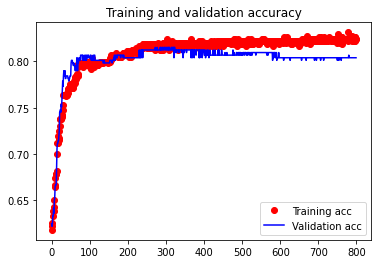

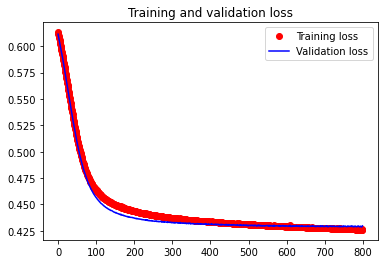

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [74]:
_, accuracy = model.evaluate(X_test, y_test_encode)
print('Accuracy: %.4f' % (accuracy*100))

12/12 [==============================] - 0s 3ms/step - loss: 0.4296 - accuracy: 0.8039
Accuracy: 80.3922


In [75]:
y_pred = model.predict(X_test)
Y_pred = np.argmax(model.predict(X_test),axis=1)
cm = confusion_matrix(y_test, Y_pred)
recall_model = cm[1][1]/(cm[0][1] + cm[1][1]) #TP/(TP+FN)
    

# Prediction using the test csv file

In [76]:
X = titanic_test.copy(deep = True)
X = X[x_cols]
X = X.apply(pd.to_numeric)
X.columns



Index(['Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2', 'sib_3', 'sib_4',
       'sib_7', 'age_30-39', 'age_40-49', 'age_60-69', 'age_20-29',
       'age_10-19', 'Age_Unknown', 'age_50-59', 'age_0-9', 'age_70-79', 'male',
       'female', 'Class_3', 'Class_2', 'Class_1', 'Q', 'S', 'C', 'U'],
      dtype='object')

In [77]:
y_pred = model.predict(X)


# Hyper-parametrisation of architecture random-walk

In [78]:
import random

best_recall_overall = recall_model

attempts = range(0,100)


for attempt in attempts:
    no_columns = X_train.shape[1]
    layers     = range(2, random.randint(3,10))
    no_nodes   = random.randint(20,50)
    
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(no_columns,)))
    
    for layer in layers:
        model.add(tf.keras.layers.Dense(no_nodes, activation="sigmoid"))
    
    
    model.add(tf.keras.layers.Dense(2, activation="softmax"))
    
    print(model.summary())
    
    best_recall = 0.0
    learning_rates = np.arange(0.0001,0.0005,0.00001)
    for rate in learning_rates:
        print("=== rates ===", rate)
        opt = tf.keras.optimizers.Adam(learning_rate = rate)
        model.compile(optimizer= opt, 
                  loss = "binary_crossentropy",
                  metrics=["accuracy"])

        history = model.fit(X_train,
                        y_train_encode,
                        validation_data=(X_test, y_test_encode),
                        epochs = 10,
                        verbose = False)
        y_pred = model.predict(X_test)
        Y_pred = np.argmax(model.predict(X_test),axis=1)
        cm = confusion_matrix(y_test, Y_pred)
        recall = cm[1][1]/(cm[0][1] + cm[1][1]) #TP/(TP+FN)
    
        if recall > best_recall:
            best_recall = recall
            best_rate   = rate 
            print("=== best recall ===" , recall)

        if best_recall == 1.0:
            learning_rates = []

    opt = tf.keras.optimizers.Adam(learning_rate = best_rate)
    model.compile(optimizer= opt, 
              loss = "binary_crossentropy",
              metrics=["accuracy"])

    history = model.fit(X_train,
                    y_train_encode,
                    validation_data=(X_test, y_test_encode),
                    epochs = 800,
                    verbose = False)
    
    _, accuracy = model.evaluate(X_test, y_test_encode)
    print('Accuracy: %.4f' % (accuracy*100))
    
    y_pred = model.predict(X_test)
    Y_pred = np.argmax(model.predict(X_test),axis=1)
    cm = confusion_matrix(y_test, Y_pred)
    recall = cm[1][1]/(cm[0][1] + cm[1][1]) #TP/(TP+FN)
    
    if recall > best_recall_overall:
        best_recall_overall = recall
        best_model = tf.keras.models.clone_model(model)
        print("=== best recall overall ===" , recall)
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 26)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 47)                1269      
_________________________________________________________________
dense_4 (Dense)              (None, 47)                2256      
_________________________________________________________________
dense_5 (Dense)              (None, 47)                2256      
_________________________________________________________________
dense_6 (Dense)              (None, 47)                2256      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 96        
Total params: 8,133
Trainable params: 8,133
Non-trainable params: 0
____________________________________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019
=== best recall === 0.95
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4345 -

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014
=== best recall === 1.0
=== rates === 0.00015000000000000001
=== rates === 0.00015999999999999999
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 1.0
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4341 - accuracy: 0.8207
Accuracy: 82.0728
=== best recall overall 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029
=== best recall === 0.7364341085271318
=== rates === 0.0003
=== best recall === 0.7441860465116279
=== rates === 0.00031
=== best recall === 0.753968253968254
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== best recall === 0.7622950819672131
=== rates === 0.00033999999999999997
=== best recall === 0.7777777777777778
=== rates === 0.00035
=== best recall === 0.8181818181818182
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== best recall === 0.8317757009345794
=== rates === 0.00037999999999999997
=== best recall === 0.8514851485148515
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== best recall === 0.8586956521739131
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.0003
=== best recall === 0.7480314960629921
=== rates === 0.00031
=== best recall === 0.7538461538461538
=== rates === 0.00031999999999999997
=== best recall === 0.7661290322580645
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== best recall === 0.7666666666666667
=== rates === 0.00035
=== best recall === 0.8035714285714286
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== best recall === 0.8256880733944955
=== rates === 0.00037999999999999997
=== best recall === 0.8529411764705882
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== best recall === 0.8736842105263158
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
=== best recall === 0.875
12/12 [==============================] - 0s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999
=== rates === 0.00017
=== best recall === 0.75
=== rates === 0.00017999999999999998
=== best recall === 0.8928571428571429
=== rates === 0.00019
=== best recall === 0.9056603773584906
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates ===

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 0.9473684210526315
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 8ms/step - loss: 0.4307 - accurac

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028
=== best recall === 0.752
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== best recall === 0.7642276422764228
=== rates === 0.00033
=== best recall === 0.7666666666666667
=== rates === 0.00033999999999999997
=== best recall === 0.7796610169491526
=== rates === 0.00035
=== best recall === 0.7844827586206896
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== best recall === 0.8240740740740741
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== best recall === 0.8365384615384616
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== best recall === 0.8514851485148515
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== best recall === 0.8571428571428571
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998
=== best recall === 0.9583333333333334
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [===========

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019
=== best recall === 1.0
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4266 - 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 0.75
=== rates === 0.00023
=== best recall === 0.9285714285714286
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.8151
Accuracy: 81.5126
Model:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017
=== best recall === 1.0
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [====

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 0.9444444444444444
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_14"
________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026
=== best recall === 0.7711864406779662
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== best recall === 0.7863247863247863
=== rates === 0.00031999999999999997
=== best recall === 0.8035714285714286
=== rates === 0.00033
=== best recall === 0.8090909090909091
=== rates === 0.00033999999999999997
=== best recall === 0.8317757009345794
=== rates === 0.00035
=== best recall === 0.86
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== best recall === 0.865979381443299
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== best recall === 0.8736842105263158
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== best recall === 0.8913043478260869
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 0.9375
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4305 - accuracy: 0.8123
Accuracy: 81.2325
Model: "sequential_16

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019
=== best recall === 0.9473684210526315
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.0003


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00031


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00031999999999999997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00033


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00033999999999999997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00035


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00035999999999999997
=== best recall === 0.7637795275590551
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== best recall === 0.78125
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== best recall === 0.8053097345132744
=== rates === 0.00047999999999999996
=== rates === 0.00049
=== best recall === 0.8256880733944955
12/12 [==============================] - 0s 4ms/step - loss: 0.4426 - accuracy: 0.7983
Accuracy: 79.8319
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 26)                0         
_________________________________________________________________
dense

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017
=== best recall === 0.9166666666666666
=== rates === 0.00017999999999999998
=== best recall === 0.9696969696969697
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023
=== best recall === 0.75
=== rates === 0.00023999999999999998
=== best recall === 0.8554216867469879
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== best recall === 0.86
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== best recall === 0.8631578947368421
=== rates === 0.00041999999999999996
=== best recall === 0.8817204301075269
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== best recall === 0.8829787234042553
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014
=== best recall === 0.9166666666666666
=== rates === 0.00015000000000000001
=== best recall === 0.9615384615384616
=== rates === 0.00015999999999999999
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023
=== best recall === 0.8732394366197183
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== best recall === 0.8829787234042553
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4328 - accuracy: 0.8207
Accuracy: 82.0728
Model: "sequential_23"
______

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 0.794392523364486
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== best recall === 0.8055555555555556
=== rates === 0.00027
=== best recall === 0.8113207547169812
=== rates === 0.00028
=== best recall === 0.8235294117647058
=== rates === 0.00029
=== best recall === 0.8484848484848485
=== rates === 0.0003
=== rates === 0.00031
=== best recall === 0.8829787234042553
=== rates === 0.00031999999999999997
=== best recall === 0.8865979381443299
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== best recall === 0.8913043478260869
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.000439999999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026
=== best recall === 1.0
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.8179
Accuracy: 81.7927
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 0.9166666666666666
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4337 - accuracy: 0.8151
Accuracy: 81.5126
Model: "s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 1.0
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4366 - accuracy: 0.8151
Accur

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 0.9285714285714286
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4347 - accurac

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026
=== best recall === 0.8947368421052632
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4367 - accuracy: 0.8123
Accuracy: 81.2325
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 1.0
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4302 - accuracy: 0.8123
Accur

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025
=== best recall === 0.9066666666666666
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4292 - accuracy: 0.8067
Accuracy: 80.6723
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Sh

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998
=== best recall === 0.9310344827586207
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [===========

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 0.95
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4325 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_34"


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019
=== best recall === 0.9705882352941176
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023
=== best recall === 0.9473684210526315
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4305 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_36"
_____________________________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 0.9459459459459459
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4337 - accuracy: 0.8151
Accuracy: 81.5126
Model: "s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 0.9482758620689655
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_38"
________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029
=== best recall === 0.8831168831168831
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.8067
Accuracy: 80.6723
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 26)                0    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019
=== best recall === 0.9259259259259259
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025
=== best recall === 0.8315789473684211
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== best recall === 0.8365384615384616
=== rates === 0.00033
=== best recall === 0.8645833333333334
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== best recall === 0.8686868686868687
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== best recall === 0.8829787234042553
=== rates === 0.00039999999999999996
=== best recall === 0.8924731182795699
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026
=== best recall === 0.7603305785123967
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== best recall === 0.7796610169491526
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== best recall === 0.7913043478260869
=== rates === 0.00033
=== best recall === 0.8035714285714286
=== rates === 0.00033999999999999997
=== best recall === 0.8365384615384616
=== rates === 0.00035
=== best recall === 0.8514851485148515
=== rates === 0.00035999999999999997
=== best recall === 0.86
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== best recall === 0.8602150537634409
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== best recall === 0.8666666666666667
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== best recall === 0.8863636363636364
=== rates === 0.00044999999999999993
=== rates === 0.0004599999999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019
=== best recall === 1.0
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4334 - 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.0003
=== best recall === 0.7480314960629921
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== best recall === 0.7538461538461538
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== best recall === 0.768595041322314
=== rates === 0.00039999999999999996
=== best recall === 0.775
=== rates === 0.00040999999999999994
=== best recall === 0.7815126050420168
=== rates === 0.00041999999999999996
=== best recall === 0.7982456140350878
=== rates === 0.00043
=== best recall === 0.8125
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== best recall === 0.8272727272727273
=== rates === 0.00047999999999999996
=== best recall === 0.8333333333333334
=== rates === 0.00049
=== best recall === 0.8421052631578947
12/12 [==========

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 1.0
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4335 - accuracy: 0.8123
Accuracy: 81.2325
Model: "sequential_45"
_______________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998
=== best recall === 0.9696969696969697
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4279 - accuracy: 0.8123
Accuracy: 81.2325
Model: "sequential_46"
_________________________________________________________________
L

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 0.8152173913043478
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== best recall === 0.8165137614678899
=== rates === 0.0003
=== best recall === 0.8484848484848485
=== rates === 0.00031
=== best recall === 0.8686868686868687
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== best recall === 0.8723404255319149
=== rates === 0.00039
=== best recall === 0.8913043478260869
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.0003
=== best recall === 0.7479674796747967
=== rates === 0.00031
=== best recall === 0.753968253968254
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== best recall === 0.7647058823529411
=== rates === 0.00036999999999999994
=== best recall === 0.782608695652174
=== rates === 0.00037999999999999997
=== best recall === 0.8108108108108109
=== rates === 0.00039
=== best recall === 0.8256880733944955
=== rates === 0.00039999999999999996
=== best recall === 0.8333333333333334
=== rates === 0.00040999999999999994
=== best recall === 0.8529411764705882
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== best recall === 0.8686868686868687
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [=========================

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019
=== best recall === 1.0
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4226 - 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 0.967741935483871
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4305 - accuracy: 0.8207
Accuracy: 82.0728
Model: "se

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001
=== best recall === 1.0
=== rates === 0.00015999999999999999
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 0.875
=== rates === 0.00023
=== best recall === 0.9178082191780822
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4319 - accuracy: 0.8151
Accuracy: 81.5126
Model

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.0003
=== best recall === 0.7586206896551724
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== best recall === 0.775
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== best recall === 0.7815126050420168
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== best recall === 0.8230088495575221
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== best recall === 0.839622641509434
=== rates === 0.00047
=== best recall === 0.8431372549019608
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4355 - accuracy: 0.8067
Accuracy: 80.6723
Model: "sequential_53"
_________________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023
=== best recall === 0.9552238805970149
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4331 - accuracy: 0.8207
Accuracy: 82.0728
Model: "sequential_54"
_____________________________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 1.0
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_55"
_______________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 0.8421052631578947
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== best recall === 0.8469387755102041
=== rates === 0.00031
=== best recall === 0.8514851485148515
=== rates === 0.00031999999999999997
=== best recall === 0.86
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== best recall === 0.8723404255319149
=== rates === 0.00039
=== best recall === 0.8817204301075269
=== rates === 0.00039999999999999996
=== best recall === 0.8913043478260869
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates ==

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026
=== best recall === 0.8421052631578947
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== best recall === 0.8673469387755102
=== rates === 0.00039999999999999996
=== best recall === 0.8854166666666666
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4283 - accuracy: 0.8095
Accuracy: 80.9524
Model: "sequential_57"
________________________________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 0.75
=== rates === 0.00021999999999999998
=== best recall === 0.8958333333333334
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4329 - accuracy: 0.8207
Ac

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 0.9285714285714286
=== rates === 0.00021
=== best recall === 0.9795918367346939
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999
=== best recall === 1.0
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025
=== best recall === 0.95
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4334 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape           

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028
=== best recall === 0.7480314960629921
=== rates === 0.00029
=== rates === 0.0003
=== best recall === 0.753968253968254
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== best recall === 0.768595041322314
=== rates === 0.00033999999999999997
=== best recall === 0.7982456140350878
=== rates === 0.00035
=== best recall === 0.8125
=== rates === 0.00035999999999999997
=== best recall === 0.8446601941747572
=== rates === 0.00036999999999999994
=== best recall === 0.8514851485148515
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== best recall === 0.8556701030927835
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== best recall === 0.8586956521739131
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 0.9583333333333334
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4325 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_63"
________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023
=== best recall === 0.8082191780821918
=== rates === 0.00023999999999999998
=== best recall === 0.8130841121495327
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== best recall === 0.8165137614678899
=== rates === 0.00031999999999999997
=== best recall === 0.8240740740740741
=== rates === 0.00033
=== best recall === 0.8529411764705882
=== rates === 0.00033999999999999997
=== best recall === 0.8631578947368421
=== rates === 0.00035
=== best recall === 0.8686868686868687
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== best recall === 0.8817204301075269
=== rates === 0.00039999999999999996
=== best recall === 0.8829787234042553
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== best recall === 0.8913043478260869
=== rates === 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002
=== best recall === 1.0
=== rates === 0.00014
=== rates === 0.00015000000000000001
=== rates === 0.00015999999999999999
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017
=== best recall === 0.8888888888888888
=== rates === 0.00017999999999999998
=== best recall === 0.9655172413793104
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999
=== best recall === 1.0
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026
=== best recall === 0.8470588235294118
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== best recall === 0.8514851485148515
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== best recall === 0.8556701030927835
=== rates === 0.00044999999999999993
=== best recall === 0.8723404255319149
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
=== best recall === 0.8817204301075269
12/12 [==============================] - 0s 3ms/step - loss: 0.4453 - accuracy: 0.8095
Accuracy: 8

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998
=== best recall === 0.8674698795180723
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4325 - accuracy: 0.8123
Accuracy: 81.2325
Model: "sequential_69"
_________________________________________________________________
L

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 0.875
=== rates === 0.00021
=== best recall === 0.8888888888888888
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/ste

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 1.0
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4323 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_71"
_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998
=== best recall === 0.9411764705882353
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4301 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_72"
_________________________________________________________________
L

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023
=== best recall === 0.75
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== best recall === 0.7647058823529411
=== rates === 0.00027
=== rates === 0.00028
=== best recall === 0.7739130434782608
=== rates === 0.00029
=== best recall === 0.8113207547169812
=== rates === 0.0003
=== best recall === 0.8349514563106796
=== rates === 0.00031
=== best recall === 0.8829787234042553
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== best recall === 0.8854166666666666
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates ==

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998
=== best recall === 1.0
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==========================

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998
=== best recall === 0.9230769230769231
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [===========

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 0.9591836734693877
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4311 - accuracy: 0.8123
Accuracy: 81.2325
Model: "sequential_76"
________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.0003


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00031


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00031999999999999997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00033
=== best recall === 0.8387096774193549
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4397 - accuracy: 0.8095
Accuracy: 80.9524
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_77 (Flatten)         (None, 26)                0         
_________________________________________________________________
dense_429 (Dense)            (

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998
=== best recall === 0.7603305785123967
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== best recall === 0.7642276422764228
=== rates === 0.00028
=== best recall === 0.8053097345132744
=== rates === 0.00029
=== best recall === 0.8090909090909091
=== rates === 0.0003
=== best recall === 0.8571428571428571
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== best recall === 0.8686868686868687
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== best recall === 0.8842105263157894
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== best recall === 0.8863636363636364
=== rates === 0.00037999999999999997
=== best recall === 0.8913043478260869
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028
=== best recall === 0.7520661157024794
=== rates === 0.00029
=== best recall === 0.7560975609756098
=== rates === 0.0003
=== rates === 0.00031
=== best recall === 0.7647058823529411
=== rates === 0.00031999999999999997
=== best recall === 0.7711864406779662
=== rates === 0.00033
=== best recall === 0.7982456140350878
=== rates === 0.00033999999999999997
=== best recall === 0.8053097345132744
=== rates === 0.00035
=== best recall === 0.8256880733944955
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== best recall === 0.8431372549019608
=== rates === 0.00037999999999999997
=== best recall === 0.86
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== best recall === 0.8602150537634409
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== best recall === 0.8681318681318682
===

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014
=== rates === 0.00015000000000000001
=== rates === 0.00015999999999999999
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.0004

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023
=== best recall === 0.8173076923076923
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== best recall === 0.8317757009345794
=== rates === 0.00031
=== best recall === 0.8365384615384616
=== rates === 0.00031999999999999997
=== best recall === 0.8431372549019608
=== rates === 0.00033
=== best recall === 0.86
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== best recall === 0.8645833333333334
=== rates === 0.00039999999999999996
=== best recall === 0.8666666666666667
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== best recall === 0.8736842105263158
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.0004599999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998
=== best recall === 0.8387096774193549
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== best recall === 0.87
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== best recall === 0.8913043478260869
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4499 - accuracy: 0.8011
Accuracy: 80.1120
Model: "sequential_83"
___

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014
=== best recall === 1.0
=== rates === 0.00015000000000000001
=== rates === 0.00015999999999999999
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 0.9411764705882353
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4304 - accurac

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.0003
=== best recall === 0.7540983606557377
=== rates === 0.00031
=== best recall === 0.7559055118110236
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== best recall === 0.7627118644067796
=== rates === 0.00035
=== best recall === 0.782608695652174
=== rates === 0.00035999999999999997
=== best recall === 0.8181818181818182
=== rates === 0.00036999999999999994
=== best recall === 0.8240740740740741
=== rates === 0.00037999999999999997
=== best recall === 0.8365384615384616
=== rates === 0.00039
=== best recall === 0.8514851485148515
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== best recall === 0.86
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 4

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 0.9318181818181818
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4324 - accurac

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 0.9230769230769231
=== rates === 0.00023
=== best recall === 0.9791666666666666
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4274 - accuracy: 0.8207
Accuracy: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017
=== best recall === 1.0
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [====

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021
=== best recall === 0.8488372093023255
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== best recall === 0.8529411764705882
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== best recall === 0.8686868686868687
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== best recall === 0.8723404255319149
=== rates === 0.00039999999999999996
=== best recall === 0.8913043478260869
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998
=== best recall === 0.9393939393939394
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4325 - accurac

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999
=== best recall === 1.0
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019
=== best recall === 1.0
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 2ms/step - loss: 0.4246 - 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017
=== best recall === 0.8
=== rates === 0.00017999999999999998
=== best recall === 0.9583333333333334
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.000479999999999

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998
=== best recall === 0.9714285714285714
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4319 - accuracy: 0.8151
Accuracy: 81.5126
Model: "sequential_95"
________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00029


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.0003


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00031


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00031999999999999997


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00033


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00033999999999999997
=== best recall === 0.7603305785123967
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== best recall === 0.7711864406779662
=== rates === 0.00039
=== best recall === 0.7982456140350878
=== rates === 0.00039999999999999996
=== best recall === 0.8198198198198198
=== rates === 0.00040999999999999994
=== best recall === 0.8256880733944955
=== rates === 0.00041999999999999996
=== best recall === 0.8301886792452831
=== rates === 0.00043
=== best recall === 0.8514851485148515
=== rates === 0.00043999999999999996
=== best recall === 0.8541666666666666
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.00049
12/12 [==============================] - 0s 3ms/step - loss: 0.4428 - accuracy: 0.8067
Accuracy: 80.6723
Model: "sequential_96"
___________________________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027
=== best recall === 0.7596899224806202
=== rates === 0.00028
=== rates === 0.00029
=== best recall === 0.7723577235772358
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== best recall === 0.773109243697479
=== rates === 0.00033
=== best recall === 0.7796610169491526
=== rates === 0.00033999999999999997
=== best recall === 0.7982456140350878
=== rates === 0.00035
=== best recall === 0.8108108108108109
=== rates === 0.00035999999999999997
=== best recall === 0.8365384615384616
=== rates === 0.00036999999999999994
=== best recall === 0.8446601941747572
=== rates === 0.00037999999999999997
=== best recall === 0.8484848484848485
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== best recall === 0.8645833333333334
=== rates === 0.00045999999999999996
=== rat

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.0004

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00019999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00021999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00023999999999999998


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00025


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00026


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00028
=== best recall === 0.75
=== rates === 0.00029
=== rates === 0.0003
=== best recall === 0.7575757575757576
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== best recall === 0.768
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== best recall === 0.768595041322314
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== best recall === 0.7815126050420168
=== rates === 0.00037999999999999997
=== best recall === 0.8017241379310345
=== rates === 0.00039
=== best recall === 0.8070175438596491
=== rates === 0.00039999999999999996
=== best recall === 0.8198198198198198
=== rates === 0.00040999999999999994
=== best recall === 0.8256880733944955
=== rates === 0.00041999999999999996
=== best recall === 0.8446601941747572
=== rates === 0.00043
=== best recall === 0.8514851485148515
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999
=== rates === 0.00017
=== rates === 0.00017999999999999998
=== rates === 0.00019
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=== rates === 0.0004

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00011


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00012


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00013000000000000002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015000000000000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00015999999999999999


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars


=== rates === 0.00017999999999999998
=== best recall === 0.9166666666666666
=== rates === 0.00019
=== best recall === 0.9302325581395349
=== rates === 0.00019999999999999998
=== rates === 0.00021
=== rates === 0.00021999999999999998
=== rates === 0.00023
=== rates === 0.00023999999999999998
=== rates === 0.00025
=== rates === 0.00026
=== rates === 0.00027
=== rates === 0.00028
=== rates === 0.00029
=== rates === 0.0003
=== rates === 0.00031
=== rates === 0.00031999999999999997
=== rates === 0.00033
=== rates === 0.00033999999999999997
=== rates === 0.00035
=== rates === 0.00035999999999999997
=== rates === 0.00036999999999999994
=== rates === 0.00037999999999999997
=== rates === 0.00039
=== rates === 0.00039999999999999996
=== rates === 0.00040999999999999994
=== rates === 0.00041999999999999996
=== rates === 0.00043
=== rates === 0.00043999999999999996
=== rates === 0.00044999999999999993
=== rates === 0.00045999999999999996
=== rates === 0.00047
=== rates === 0.00047999999999999996
=

In [79]:
best_model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_42 (Flatten)         (None, 26)                0         
_________________________________________________________________
dense_230 (Dense)            (None, 33)                891       
_________________________________________________________________
dense_231 (Dense)            (None, 33)                1122      
_________________________________________________________________
dense_232 (Dense)            (None, 33)                1122      
_________________________________________________________________
dense_233 (Dense)            (None, 2)                 68        
Total params: 3,203
Trainable params: 3,203
Non-trainable params: 0
_________________________________________________________________
